## Object Detection

This is a notebooks from [AI for Beginners Curriculum](http://aka.ms/ai-beginners)

![Image Algorithms](https://cdn-images-1.medium.com/max/840/1*Hz6t-tokG1niaUfmcysusw.jpeg)

## Naive Approach to Object Detection

* Break image into tiles
* Run CNN image classified through each time
* Select tiles with activation above the threshold

In [11]:
import cv2
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os

Let's read sample image to play with and pad it to square dimension:

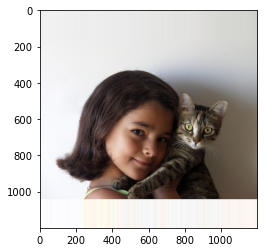

In [19]:
img = cv2.imread('images/1200px-Girl_and_cat.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = np.pad(img,((158,158),(0,0),(0,0)),mode='edge')
plt.imshow(img)

We will use pre-trained VGG-16 CNN:

In [14]:
vgg = keras.applications.vgg16.VGG16(weights='imagenet')

Let's define a function that will predict the probability of a cat on the image. Since ImageNet contains a number of classes for cats, indexed from 281 to 294, we will just add probabilities for those classes to get overall 'cat' probability:

In [15]:
def predict(img):
  im = cv2.resize(img,(224,224))
  im = keras.applications.vgg16.preprocess_input(im)
  pr = vgg.predict(np.expand_dims(im,axis=0))[0]
  return np.sum(pr[281:294]) # we know that VGG classes for cats are from 281 to 294

predict(img)

0.61825

Next function will build a heatmap of probabilities, dividing the image into $n\times n$ squares:

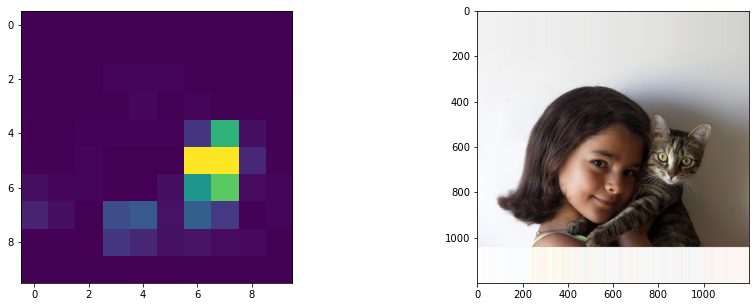

In [20]:
def predict_map(img,n):
  dx = img.shape[0] // n
  res = np.zeros((n,n),dtype=np.float32)
  for i in range(n):
    for j in range(n):
      im = img[dx*i:dx*(i+1),dx*j:dx*(j+1)]
      r = predict(im)
      res[i,j] = r
  return res

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[1].imshow(img)
ax[0].imshow(predict_map(img,10))

## Detecting Simple Objects

To give more precise location of a bounding box, we need to run **regression model** to predict bounding box coordinates. Let's start with simple example of having black rectangles in 32x32 images, which we want to detect. The idea and some code are borrowed from [this blog post](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491).

The following function will generate a bunch of sample images:

In [113]:
def generate_images(num_imgs, img_size=8, min_object_size = 1, max_object_size = 4):
    bboxes = np.zeros((num_imgs, 4))
    imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

    for i_img in range(num_imgs):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img] = [x, y, w, h]
    return imgs, bboxes

imgs, bboxes = generate_images(100000)
print(f"Images shape = {imgs.shape}")
print(f"BBoxes shape = {bboxes.shape}")

Images shape = (100000, 8, 8)
BBoxes shape = (100000, 4)


To make outputs of the network in the range [0;1], we will divide `bboxes` by the image size:

In [114]:
bb = bboxes/8.0
bb[0]

array([0.   , 0.25 , 0.125, 0.25 ])

In our simple example, we will use dense neural network. In real life, when objects have more complex shape, it definitely makes sense to use CNNs for the task like this. We will use stochastic gradient descent optimizer and mean squared error (MSE) as the metrics, because our task is **regression**.

In [144]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(8,8)),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4)
])
model.compile('sgd','mse')
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 64)                0         
                                                                 
 dense_50 (Dense)            (None, 200)               13000     
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_51 (Dense)            (None, 4)                 804       
                                                                 
Total params: 13,804
Trainable params: 13,804
Non-trainable params: 0
_________________________________________________________________


Let's train our network. We will also normalize the input data (by subtracting mean and dividing by standard deviation) for slightly better performance.

In [145]:
imgs_norm = (imgs-np.mean(imgs))/np.std(imgs)
model.fit(imgs_norm,bb,epochs=30)

Epoch 1/30
3125/3125 [==============================] - 6s 2ms/step - loss: 0.0562
Epoch 2/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0131
Epoch 3/30
3125/3125 [==============================] - 5s 1ms/step - loss: 0.0076
Epoch 4/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0058
Epoch 5/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0050
Epoch 6/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0044
Epoch 7/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0041
Epoch 8/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0038
Epoch 9/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0036
Epoch 10/30
3125/3125 [==============================] - 6s 2ms/step - loss: 0.0034
Epoch 11/30
3125/3125 [==============================] - 8s 3ms/step - loss: 0.0033
Epoch 12/30
3125/3125 [==============================] - 8s 3ms/step - loss: 0.0031
E

We seem to have relatively good loss, let's see how it translates into more tangible metrics, such as mAP. First, let's define IOU metric between two bounding boxes:

In [146]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]
    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

We will now generate 500 test images, and plot first 5 of them to visualize how accurate we are. We will print out IOU metric as well.

pred=[3.7325673 3.6551285 2.0126944 1.030895 ],act=[4. 4. 2. 1.], IOU=0.41607480412565545
pred=[2.3762555 3.755858  1.1647941 1.0540264],act=[2. 4. 1. 1.], IOU=0.2932611042051458
pred=[-0.04900682 -0.10628867  2.7881489   1.027148  ],act=[0. 0. 3. 1.], IOU=0.7548650953478908
pred=[0.96806276 4.267275   1.3179774  1.1021365 ],act=[0. 5. 1. 1.], IOU=0.004833667961256898
pred=[2.157959   0.94667876 2.7568097  0.96259   ],act=[2. 1. 3. 1.], IOU=0.7965311752734529


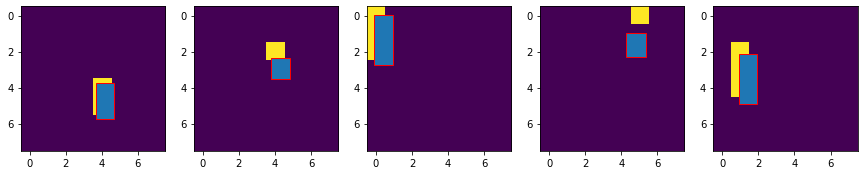

In [149]:
import matplotlib

test_imgs, test_bboxes = generate_images(500)
bb_res = model.predict((test_imgs-np.mean(imgs))/np.std(imgs))*8

plt.figure(figsize=(15,5))
for i in range(5):
    print(f"pred={bb_res[i]},act={test_bboxes[i]}, IOU={IOU(bb_res[i],test_bboxes[i])}")
    plt.subplot(1,5,i+1)
    plt.imshow(test_imgs[i])
    plt.gca().add_patch(matplotlib.patches.Rectangle((bb_res[i,1],bb_res[i,0]),bb_res[i,3],bb_res[i,2],ec='r'))
    #plt.annotate('IOU: {:.2f}'.format(IOU(bb_res[i],test_bboxes[i])),(bb_res[i,1],bb_res[i,0]+bb_res[i,3]),color='y')


Now to calculate mean precision over all cases, we just need to go over all our test samples, compute IoU, and calculate mean:

In [151]:
np.array([IOU(a,b) for a,b in zip(test_bboxes,bb_res)]).mean()

0.7150587956049862

## Real-Life Object Detection

Real object detection algorithms are more complicated. We will recommend you to follow [Keras tutorial on Object Detection with RetinaNet](https://keras.io/examples/vision/retinanet/) if you want to get into the details of RetinaNet implementation, or use [Keras RetinaNet Library](https://github.com/fizyr/keras-retinanet), if you just want to train object detection model.